# Multistage newsvendor problem

## Usando Biblioteca SDDP

In [2]:
using SDDP, Distributions, Gurobi
gurobi_env = Gurobi.Env()

graph = SDDP.Graph(
           :root_node,
           [:decision_node,:demand_node,:decision_node2,:demand_node2],
           [
               (:root_node => :decision_node, 1.0),
               (:decision_node => :demand_node, 1.0),
               (:demand_node => :decision_node2, 1.0),
               (:decision_node2 => :demand_node2, 1.0)

           ]);

println("Defino Modelo...")

p = 1.0 #day ahead price
q = 2.0 #same day price

model = SDDP.PolicyGraph(
            graph,
            sense = :Min,
            lower_bound = 0,
            optimizer = optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0) ) do subproblem, node

                @variable(subproblem, stock>=0, SDDP.State, initial_value = 0)

                @variable(subproblem, 0 <= reserve)
                @variable(subproblem, 0 <= shortage)

                @variable(subproblem, demand)

                @constraint(subproblem, stock.out == stock.in + reserve + shortage - demand)

                if node == :decision_node || node == :decision_node2
                        JuMP.fix(demand,0.0)
                        JuMP.fix(shortage,0.0;force=true)
                else
                    demand_range = collect(0:100);
#                    demand_probability = pdf.(Poisson(20),demand_range);
                    demand_probability = ones(size(demand_range));
                    demand_probability ./= sum(demand_probability);

                    SDDP.parameterize(subproblem,demand_range,demand_probability) do d
                        JuMP.fix(demand,d)
                        JuMP.fix(reserve,0.0;force=true)
                    end
                end


                if node == :decision_node || node == :decision_node2
                    @stageobjective(subproblem,  p*reserve);
                else
                    @stageobjective(subproblem,  q*shortage);
                end
            end;

SDDP.train(model, iteration_limit=30)
#SDDP.train(model,risk_measure = SDDP.AVaR(0.5),iteration_limit=20)

results=SDDP.simulate(model,1000,[:reserve,:stock,:demand,:shortage]);

Academic license - for non-commercial use only - expires 2021-03-16
Defino Modelo...
------------------------------------------------------------------------------
                      SDDP.jl (c) Oscar Dowson, 2017-21

Numerical stability report
  Non-zero Matrix range     [1e+00, 1e+00]
  Non-zero Objective range  [1e+00, 2e+00]
  Non-zero Bounds range     [0e+00, 0e+00]
  Non-zero RHS range        [0e+00, 0e+00]
No problems detected

Solver: serial mode

 Iteration    Simulation       Bound         Time (s)    Proc. ID   # Solves
        1    8.400000e+01   7.500000e+01   1.500730e+01          1        208
        2    1.700000e+02   1.179407e+02   1.526501e+01          1        416
        3    1.179407e+02   1.238477e+02   1.527407e+01          1        624
        4    9.333577e+01   1.265038e+02   1.528327e+01          1        832
        5    8.227228e+01   1.273050e+02   1.529341e+01          1       1040
        6    1.248424e+02   1.275965e+02   1.530243e+01          1    

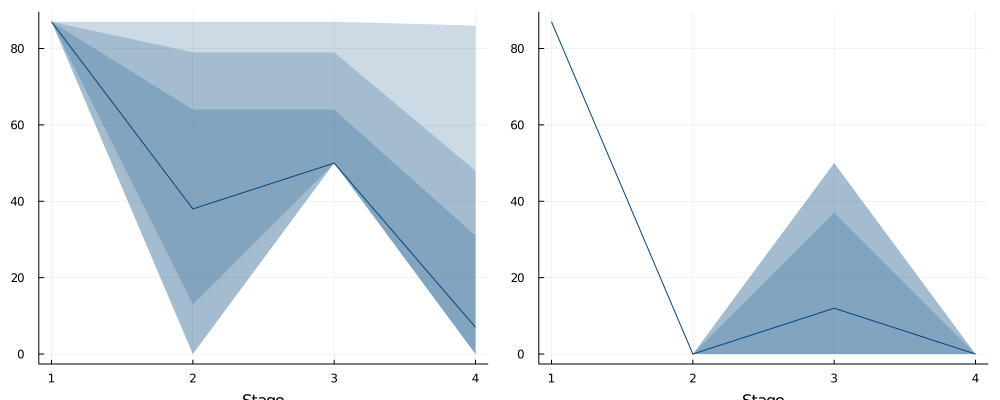

In [3]:
using Plots
plot(
    SDDP.publication_plot(results, title = "Stock") do data
        return data[:stock].out
    end,
    SDDP.publication_plot(results, title = "Purchase") do data
        return data[:reserve]
    end,
    xlabel = "Stage",
    layout = (1, 2),
    size = (1000, 400)
)


## Multistage newsvendor with Stochastic Decomposition

In [19]:
function piecewise_linear(x,cuts)
    
    return maximum([cut[1]+cut[2]*x for cut in cuts])
end

piecewise_linear (generic function with 1 method)

In [45]:
#array de vectores de cuts. Arranca en la lower bound
cuts1 = [[0.0;0.0]];
cuts2 = [[0.0;0.0]];

#aca guardo solo los multiplicadores
duals1 = Set{Float64}();
duals2 = Set{Float64}();

#aca guardo los ruidos que fueron saliendo
noises1 = Array{Float64}(undef,0);
noises2 = Array{Float64}(undef,0);

#condicion inicial de stock
x0=0.0;



In [46]:
using ProgressMeter
@showprogress 1 "Computing..." for l=1:2000
    
    ##FORWARD
    
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,reserve>=0);
    @variable(model,stock>=0);
    @variable(model,z);

    cut_constraints = [];
    for k=1:length(cuts1)
        cut=cuts1[k]
        c=@constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
        push!(cut_constraints,c);
    end

    fix_x = @constraint(model,stock==x0);

    @objective(model,Min,p*reserve+z);

    optimize!(model)

    x1=value(stock)+value(reserve);
    #
    
    #sorteo la demanda
    d1=rand(DiscreteUniform(0,100));
    x1post = max(x1-d1,0)
    
    ##resuelvo el segundo paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,reserve>=0);
    @variable(model,stock>=0);
    @variable(model,z);

    cut_constraints = [];
    for k=1:length(cuts2)
        cut=cuts2[k]
        c=@constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
        push!(cut_constraints,c);
    end

    fix_x = @constraint(model,stock==x1post);

    @objective(model,Min,p*reserve+z);

    optimize!(model)

    x2=value(stock)+value(reserve);
    #fin segundo paso
    
    ## no calcule los costos, faltaría calcular el shortage incurrido en cada paso.

    d2=rand(DiscreteUniform(0,100));
    push!(noises1,d1)
    push!(noises2,d2)
    

    ##BACKWARD
    
    #Segundo paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,shortage>=0);
    @variable(model,stock>=0);

    fix_x = @constraint(model,x2-d2+shortage>=0);
    @objective(model,Min,q*shortage);

    optimize!(model)

    beta = objective_value(model);
    lambda = dual(fix_x)

    push!(duals2,lambda)

    #update all previous cuts for averaging
    for j=1:length(cuts2)
        cuts2[j] = (l-1)/l * cuts2[j];
    end

    pik = similar(noises2);
    #genero el new cut recorriendo todos los ruidos
    for j=1:length(noises2)
        aux = [(pi*(noises2[j]-x2),pi) for pi in duals2]
        _, ix = findmax([a[1] for a in aux])
        pik[j] = aux[ix][2];
    end

    new_cut  = 1/l * [ sum(pik.*noises2); -sum(pik) ];

    push!(cuts2,new_cut);
    
    #Primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,shortage>=0);
    @variable(model,stock>=0);
    @variable(model,z);
    
    cut_constraints = [];
    for k=1:length(cuts2)
        cut=cuts2[k]
        c=@constraint(model,z>=cut[1]+cut[2]*(stock));
        push!(cut_constraints,c);
    end
    
    fix_x = @constraint(model,x1-d1+shortage==stock);
    @objective(model,Min,q*shortage+z);

    optimize!(model)

    beta = objective_value(model);
    lambda = dual(fix_x)

    push!(duals1,lambda)

    #update all previous cuts for averaging
    for j=1:length(cuts1)
        cuts1[j] = (l-1)^2/l^2 * cuts1[j];
    end

    pik = similar(noises1);
    #genero el new cut recorriendo todos los ruidos
    for j=1:length(noises1)
        aux = [(pi*(noises1[j]-x1),pi) for pi in duals1]
        _, ix = findmax([a[1] for a in aux])
        pik[j] = aux[ix][2];
    end

    new_cut  = 1/l * [ sum(pik.*noises1); -sum(pik) ];

    push!(cuts1,new_cut);
    
end

Computing...100%|███████████████████████████████████████| Time: 0:09:04


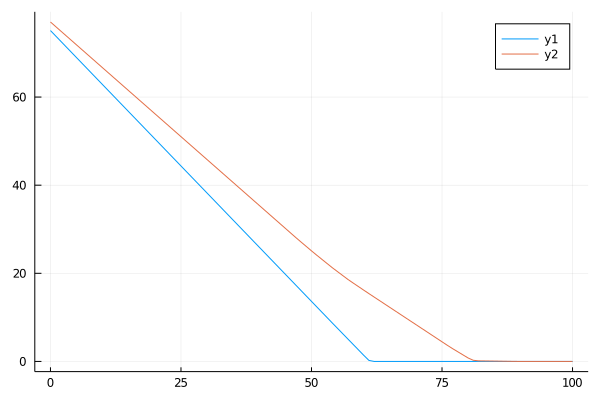

In [47]:
x=(0:100)

plot(x,piecewise_linear.(x,Ref(cuts1)))
plot!(x,piecewise_linear.(x,Ref(cuts2)))

In [48]:
##FORWARD de nuevo
    
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,reserve>=0);
    @variable(model,stock>=0);
    @variable(model,z);

    cut_constraints = [];
    for k=1:length(cuts1)
        cut=cuts1[k]
        c=@constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
        push!(cut_constraints,c);
    end

    fix_x = @constraint(model,stock==x0);

    @objective(model,Min,p*reserve+z);

    optimize!(model)

    x1=value(stock)+value(reserve);


In [49]:
x1

61.1953068095735